#### Smart Home Data [source](https://www.kaggle.com/code/offmann/smart-home-dataset/input)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

ModuleNotFoundError: No module named 'seaborn'

: 

In [2]:
df = pd.read_csv("data/HomeC.csv.zip")
df.head()

C:\Users\jacki\AppData\Local\Temp\ipykernel_17400\495701789.py:1: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/HomeC.csv.zip")


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [3]:
df.isna().sum().sort_values(ascending=False).head(1)

Microwave [kW]    1
dtype: int64

In [4]:
df.shape

(503911, 32)

In [5]:
df.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

#### Data preprocessing

In [6]:
# Rename columns to remove spaces and the kW unit 
df.columns = [col[:-5].replace(' ','_') if 'kW' in col else col for col in df.columns]

# Drop rows with nan values 
df = df.dropna()

# The columns "use" and "house_overall" are the same, so let's remove the 'house_overall' column
df.drop(['House_overall'], axis=1, inplace=True)

# The columns "gen" and "solar" are the same, so let's remove the 'solar' column
df.drop(['Solar'], axis=1, inplace=True)

# drop rows with cloudCover column values that are not numeric (bug in sensors) and convert column to numeric
df = df[df['cloudCover']!='cloudCover']
df["cloudCover"] = pd.to_numeric(df["cloudCover"])

# Create columns that regroup kitchens and furnaces 
df['kitchen'] = df['Kitchen_12'] + df['Kitchen_14'] + df['Kitchen_38']
df['Furnace'] = df['Furnace_1'] + df['Furnace_2']

# Convert "time" column (which is a unix timestamp) to a Y-m-d H-M-S 
import time 
start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(df['time'].iloc[0])))
time_index = pd.date_range(start_time, periods=len(df), freq='min')  
time_index = pd.DatetimeIndex(time_index)
df = df.set_index(time_index)
df = df.drop(['time'], axis=1)

In [7]:
# Helpful functions

# lower first letter of a string  
func = lambda s: s[:1].lower() + s[1:] if s else ''

# Remove rows with values that appear less than a certain percentage %
def remove_less_percent(col, percent):
    keys_to_conserve = [key for key,value in df[col].value_counts(normalize=True).items() if value>=percent]
    return df[df[col].isin(keys_to_conserve)]


In [8]:
cols = list(df.dtypes.keys())
categ_cols = [col for col in cols if df[col].dtype=='O']
num_cols = [col for col in cols if col not in categ_cols]
print('categ_cols : ', categ_cols)
print('num_cols : ', num_cols)

categ_cols :  ['icon', 'summary']
num_cols :  ['use', 'gen', 'Dishwasher', 'Furnace_1', 'Furnace_2', 'Home_office', 'Fridge', 'Wine_cellar', 'Garage_door', 'Kitchen_12', 'Kitchen_14', 'Kitchen_38', 'Barn', 'Well', 'Microwave', 'Living_room', 'temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability', 'kitchen', 'Furnace']


In [9]:
print(len(df))
df = remove_less_percent('summary', 0.05)
print(len(df))
df = remove_less_percent('icon', 0.05)
print(len(df))

503852
466308
466308


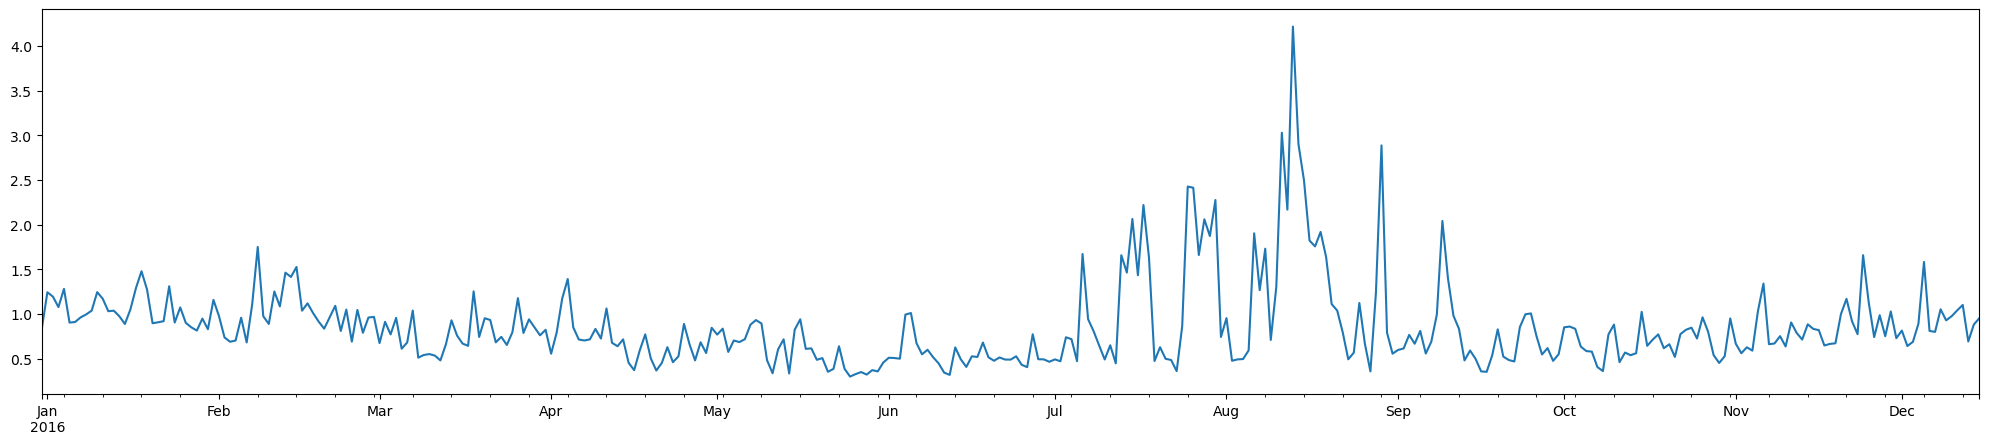

In [10]:
# plot use intensity by day, rolling daily average

use = df['use'].resample(rule='D').mean().plot(figsize=(25,5));

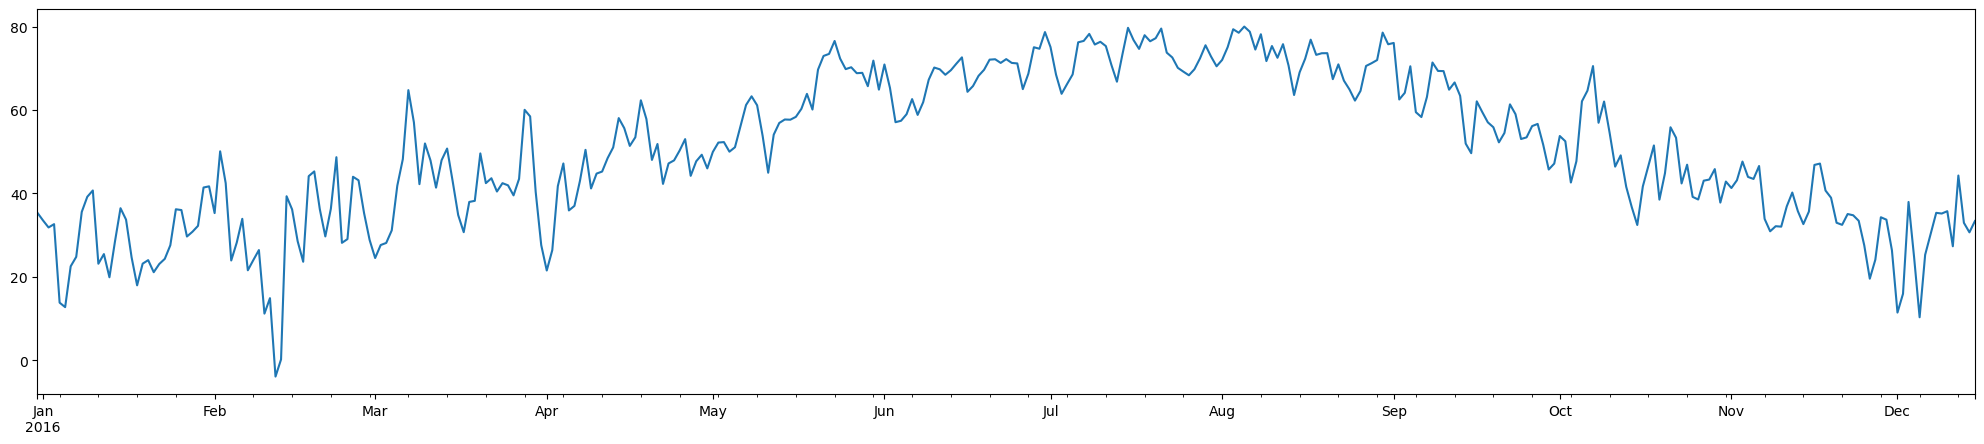

In [11]:
# plot temperature by day, rolling daily average

temp = df['temperature'].resample(rule='D').mean().plot(figsize=(25,5));

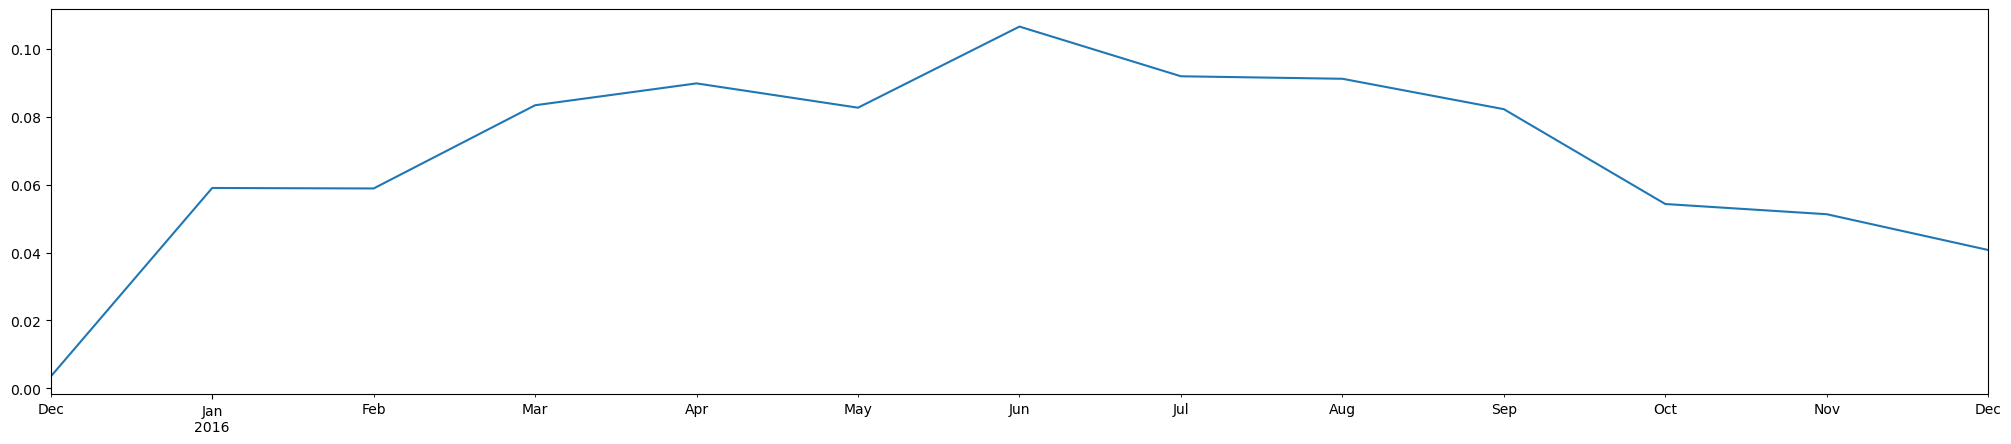

In [12]:
# plot renewable generation by month, rolling monthly average

gen = df['gen'].resample(rule='M').mean().plot(figsize=(25,5));

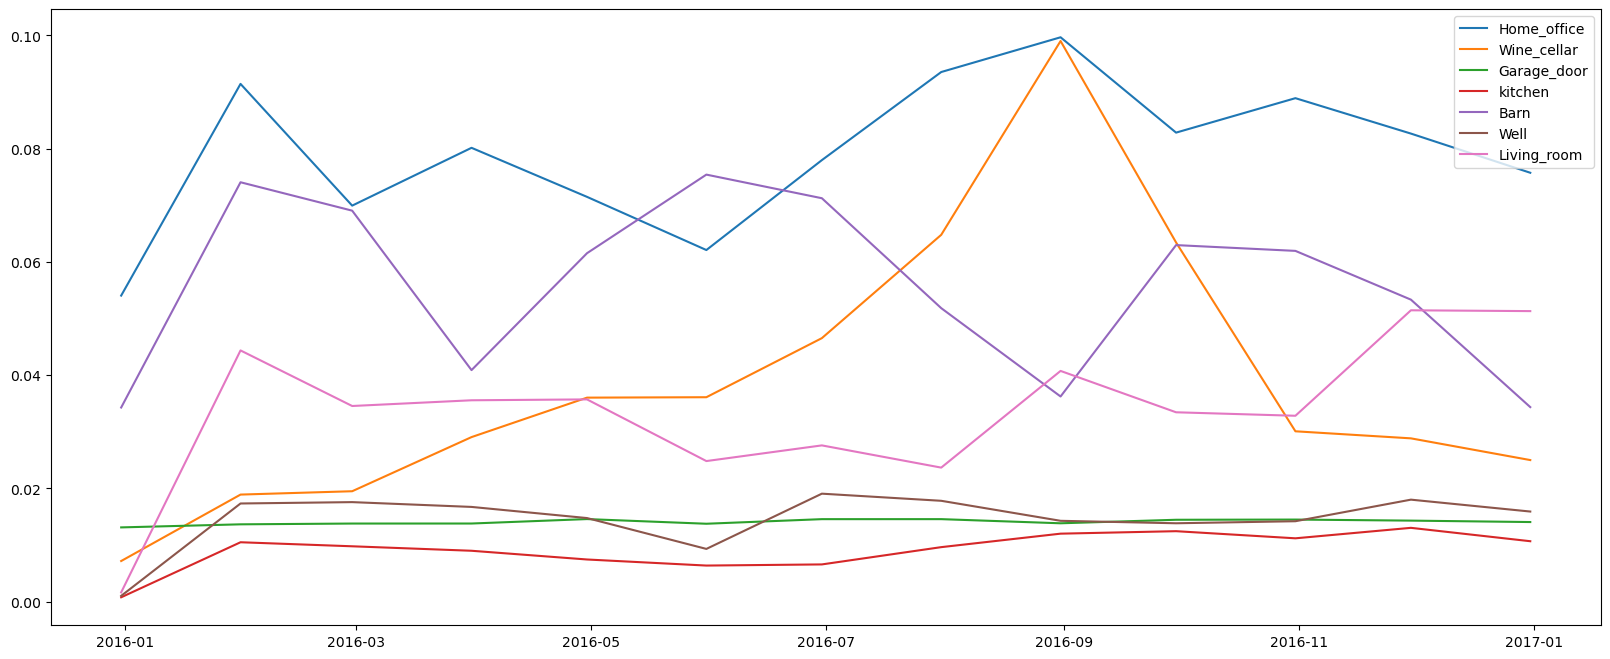

In [13]:
# plot room energy by month, rolling monthly average

rooms_energy_cols = ['Home_office', 'Wine_cellar','Garage_door',
                       'kitchen', 'Barn', 'Well','Living_room']

rooms_energy_per_month = df[rooms_energy_cols].resample('M').mean()   

plt.figure(figsize=(20,8))

room = sns.lineplot(data=rooms_energy_per_month, dashes=False);

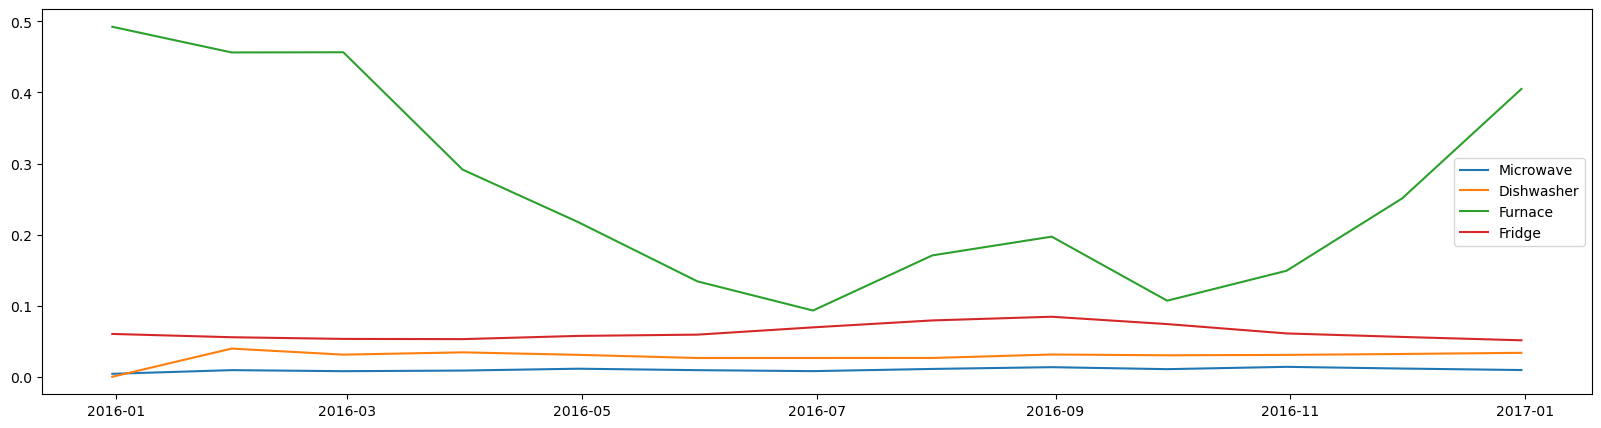

In [14]:
# plot equipment energy use by month, rolling monthly average

equipments_cols = ['Microwave', 'Dishwasher', 'Furnace', 'Fridge'] 

equipments_energy_per_month = df[equipments_cols].resample('M').mean()   

plt.figure(figsize=(20,5))

equip = sns.lineplot(data= equipments_energy_per_month, dashes=False);

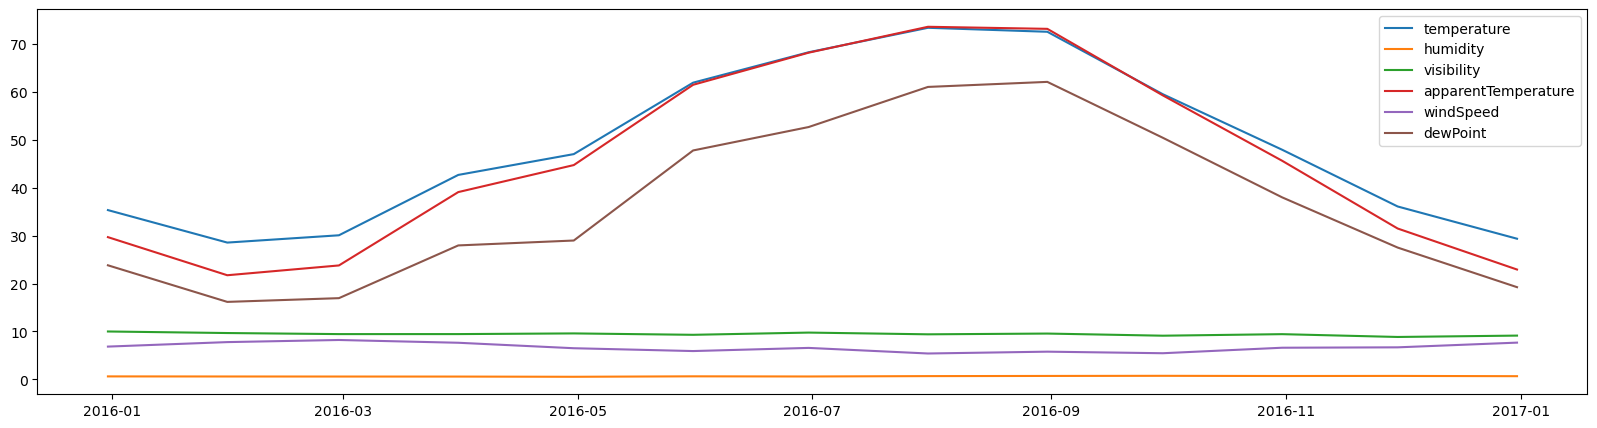

In [15]:
# plot weather by month, rolling monthly average

weather_columns = ['temperature','humidity', 'visibility', 'apparentTemperature', 
                   'windSpeed', 'dewPoint']

weather_per_month = df[weather_columns].resample('M').mean()   

plt.figure(figsize=(20,5))

weather = sns.lineplot(data=weather_per_month, dashes=False); 

### Comparing Energy usage vs different weather metrics

In [16]:
weather = df[['use', 'Fridge', 'Microwave', 'temperature','humidity', 'visibility', 'apparentTemperature', 
                   'windSpeed', 'dewPoint']]
weather.corr()

,use,Fridge,Microwave,temperature,humidity,visibility,apparentTemperature,windSpeed,dewPoint
use,1.000000,0.150236,0.108282,0.010238,0.009963,0.000591,0.004980,0.001662,0.015212
Fridge,0.150236,1.000000,0.025649,0.105403,0.031016,0.006629,0.105087,-0.023049,0.112918
Microwave,0.108282,0.025649,1.000000,0.003595,0.006631,-0.006591,0.004541,-0.003450,0.006141
temperature,0.010238,0.105403,0.003595,1.000000,-0.079518,0.051403,0.993394,-0.065701,0.889809
humidity,0.009963,0.031016,0.006631,-0.079518,1.000000,-0.499988,-0.035820,-0.450013,0.374935
visibility,0.000591,0.006629,-0.006591,0.051403,-0.499988,1.000000,0.034747,0.192798,-0.148447
apparentTemperature,0.004980,0.105087,0.004541,0.993394,-0.035820,0.034747,1.000000,-0.137263,0.901161
windSpeed,0.001662,-0.023049,-0.003450,-0.065701,-0.450013,0.192798,-0.137263,1.000000,-0.245955
dewPoint,0.015212,0.112918,0.006141,0.889809,0.374935,-0.148447,0.901161,-0.245955,1.000000


C:\Users\jacki\AppData\Local\Temp\ipykernel_17400\2572165783.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_norm[i] = stats.zscore(weather[i])


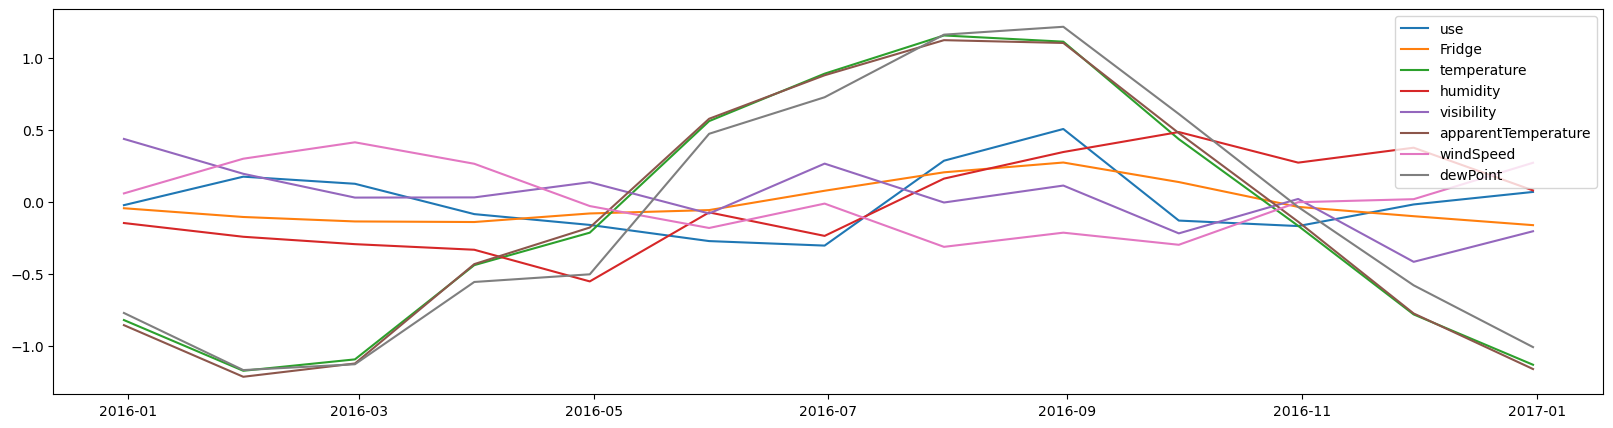

In [17]:
# plot weather by month, rolling monthly average

weather_norm = weather

for i in weather.columns:
    weather_norm[i] = stats.zscore(weather[i])

weather_columns = ['use', 'Fridge', 'temperature','humidity', 'visibility', 'apparentTemperature', 
                   'windSpeed', 'dewPoint']

weather_per_month = weather_norm[weather_columns].resample('M').mean()   

plt.figure(figsize=(20,5))

weather_chart = sns.lineplot(data=weather_per_month, dashes=False); 

[]

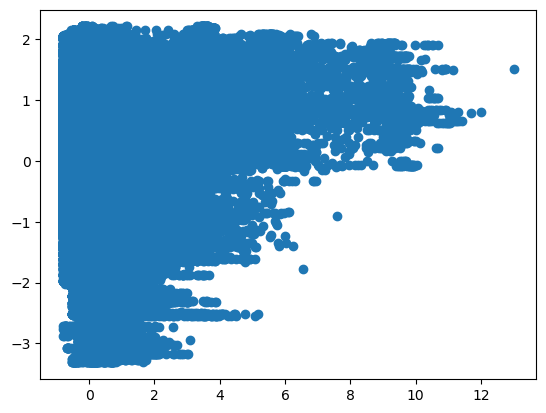

In [18]:
plt.scatter(weather_norm['use'], weather_norm['temperature'])
plt.plot()

[]

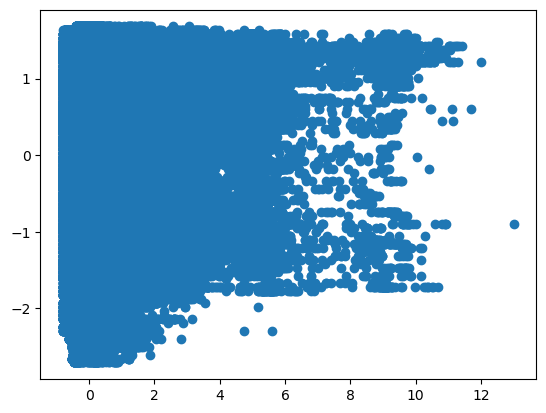

In [19]:
plt.scatter(weather_norm['use'], weather_norm['humidity'])
plt.plot()

[]

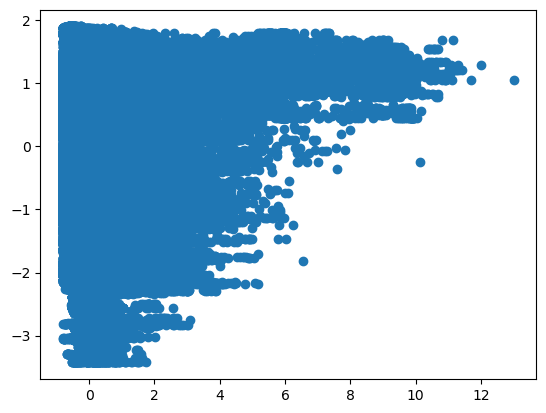

In [20]:
plt.scatter(weather_norm['use'], weather_norm['dewPoint'])
plt.plot()

- Energy bills tend to be lower in spring and fall because the weather is milder, reducing the need for heating or cooling.
- Your energy bill might be higher in summer because air conditioning usage increases to keep your home cool during hot weather.
- Longer Days, More Activity: While longer daylight might reduce lighting costs, people often engage in more energy-intensive activities, such as running pool pumps or outdoor appliances.

- Energy bills tend to be lower in spring and fall because the weather is milder, reducing the need for heating or cooling.
- Appliances such as refrigerators and freezers work more efficiently in moderate temperatures, which may contribute to lower energy consumption.

#### Problem:  

1. Change Detection : Detecting excessive energy consumption in advance and preventing increase in usage fees.

1. Utility Bill Explanation : Segment systems using energy to identify source(s) of bill increases and pain points.

1. <i>(unpreferred but is an option)</i> Predict Future Consumption : Predicting future energy consumption and generation by utilizing weather information and optimizing energy supply.

#### Testing ways to let LLM read and understand tabular data

In [21]:
print(df.resample(rule='M').mean().to_string())

TypeError: Could not convert clear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-nightclear-night to numeric

In [ ]:
df.columns

In [ ]:
# separate columns related to energy consumption

uses = df[[col for col in df.columns if col not in weather_columns+[
    'cloudCover', 'precipIntensity', 'precipProbability', 'windBearing', 'icon', 
    'summary', 'pressure']]]

use_str = uses.resample(rule='M').mean().to_string()

print(use_str)

In [ ]:
# prepare a sample

sample_data = use.head(10).to_csv(index=False)
print(sample_data)

In [ ]:
# combine the details

data_description = f"""
The dataset contains the following columns:
{', '.join(use.columns)}

Column description (everything in kilowatt):
"use" contains total energy consumption
"gen" contains total energy generated by means of solar or other power generation resources
The rest of the columns either contain energy consumed by a specific appliance or room in the house

Summary usage by month:
{use_str}

Sample data:
{sample_data}
"""

In [ ]:
print(data_description)

In [ ]:
# !pip install openai python-dotenv -q

In [ ]:
import openai 
from dotenv import load_dotenv
import os 

load_dotenv()

GPT_MODEL = 'gpt-4o'

In [ ]:
# API Configuration
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
# prepare prompt

prompt = f"""
This is a time-series dataset of utility usage for a smart home:
{data_description}

Please answer the following questions:
1. Identify any sources with an increasing trend in electricity usage over time. 
2. Highlight any significant outliers or anomalies. 
"""

In [ ]:
# prepare 

messages = [
        {"role": "system", "content": 
        
        "You are a smart home utility data analyst conversing with the homeowner directly. Be precise, concise, and keep the response within a comfortable length for the homeowner to read conveniently and understand their utility usage with actionable insights to pinpoint inefficiencies."
        
        },

        {"role": "user", "content": prompt},
    ]

response = openai.chat.completions.create(
    model=GPT_MODEL, messages=messages
    )

In [ ]:
print(response.choices[0].message.content)

#### sanity check

To identify trends and anomalies in your smart home utility usage data, I have analyzed the time-series provided. Here are my findings:

1. **Increasing Trends in Usage:**
   - **Wine Cellar:** There's a noticeable increase in energy usage in the Wine Cellar from December 2015 (0.0072 kW) to August 2016 (0.0990 kW). This suggests a potential increase in cooling requirements or operational inefficiencies.
   - **Home Office:** Usage starts at 0.0540 kW in December 2015 and peaks in August 2016 at 0.0997 kW. This trend might align with greater work-from-home demand.

2. **Significant Outliers or Anomalies:**
   - **Furnace Usage:** Particularly high in December 2015 (0.4924 kW) and December 2016 (0.4049 kW), likely due to heating needs in winter months; however, it's a notable concentration of usage.
   - **August 2016:** Total usage spikes to 1.4009 kW, significantly higher than other months. The contributing factors include increased usage in the Wine Cellar, Fridge, and Home Office. This indicates potential excess cooling or a specific occasion causing higher usage.
   - **Energy Generation:** Energy generation is consistently lower than overall usage, with small fluctuations, except notable higher generation in June 2016 (0.1066 kW), possibly indicating peak solar efficiency.

**Actionable Insights:**
- Consider inspecting and potentially upgrading the cooling system in the Wine Cellar.
- Verify if there is room for optimization in energy usage in the Home Office, especially during summer months.
- Regularly maintain and assess the Furnace to ensure peak efficiency, especially before the heating season.
- Explore potential enhancements or expansions to your energy generation system to better align with high usage periods.

By addressing these areas, you can likely reduce excess usage and improve energy efficiency in your home.

In [ ]:
print(prompt)

In [ ]:
# check total use

use.get_figure()

In [ ]:
# check equipments 

equip.get_figure()

In [ ]:
# check locations

room.get_figure()

In [ ]:
df.columns

### Two functionalities

1. Summary report (Spotify wrapped)
1. Utility bill explanation

### Work distribution

#### Data split

OVERALL: use, gen 

APPLIANCES: dishwasher, fridge, wine cellar, microwave, garage door, furnace (sum of furnace 1 / 2) - Eric

LOCATIONS: home office, barn, well, living room, kitchen (sum kitchen 12 / 14 / 38) - Bofu

WEATHER: temperature, icon, humidity, visibility, summary, apparentTemperature, 
       pressure, windSpeed, cloudCover, windBearing, precipIntensity,
       dewPoint, precipProbability - Daniel

#### RAG split

Decode Your Power Bill (Daniel and Bofu)

Utility Price (we can assume Colorado or Lake Tahoe) (Phu and Eric)

#### Guardrail split (NeMo)

Input moderation 

RAG evaluation

Output moderation

### Development strategy

Test scenario / guardrail formation (5 each)
1. Peform EDA to figure out an exact answer to a specific user prompt (ex: Furnace_2 used most energy, on average, in Dec 2015) 
1. Draft the user prompt (string)
1. Develop a fact-check guardrail to test the tool 

RAG strategy

Start with the tokenize and similarity search approach (traditional); otherwise, use string context as a simple backup (Zayd's example from Fall)


In [ ]:
df.icon.unique()

In [ ]:
df.summary.unique()

In [ ]:
r = df.apparentTemperature / df.temperature
r

In [ ]:
df[r==max(r)][['temperature', 'apparentTemperature']]

In [ ]:
r.describe()

In [ ]:
df.summary.tail(10)

In [ ]:
f = df[['Kitchen_38','Kitchen_14', 'Kitchen_12', 'kitchen']]
f

In [ ]:
f.Kitchen_38 + f.Kitchen_14 + f.Kitchen_12

In [ ]:
uses.resample(rule='M').mean().iloc[0].sort_values(ascending=False)